In [93]:
import os

import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 5)

from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate

In [94]:
DATA_DIR = '/Users/alpombeo/Downloads/'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
MASK_DIR = os.path.join(DATA_DIR, 'train_masks')
TRAIN_IMAGE_LIST = os.listdir(TRAIN_DIR)
MASK_IMAGE_LIST = os.listdir(MASK_DIR)
ASPECT_RATIO = 1280 / 1918

In [99]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [100]:
def kmeans_img(img, target_colors = 64):
    
    new_img = np.zeros(img.shape)
    for ix in range(img.shape[0]):
        
        img_temp = img[ix]
        image_array = img_temp.reshape((img_temp.shape[0]*img_temp.shape[1],img_temp.shape[2]))
        image_array_sample = shuffle(image_array, random_state=0)[:1000]
        kmeans = KMeans(n_clusters=target_colors, random_state=0).fit(image_array_sample)
        labels = kmeans.predict(image_array)
        new_img[ix] = recreate_image(kmeans.cluster_centers_, labels, img[ix].shape[0], img[ix].shape[1])
        
    return new_img

In [112]:
def image_generator_function(batch_size, img_width = None,colors=12):
    
    '''
    batch_size: The number of images to be consider in one batch.
    colors = target number of colors for kmeans algorithm
    img_width: The width to which the original image is resized while maintaining aspect ratio. Does not resize if no parameters passed.
    '''
    
    img_dim = None
    if img_width is not None:
        img_dim = [int(ASPECT_RATIO * img_width), img_width]
    
    while True:
        random_indices = np.random.choice(len(TRAIN_IMAGE_LIST), batch_size)
        
        imgs = [img_to_array(load_img(os.path.join(TRAIN_DIR, TRAIN_IMAGE_LIST[index]), target_size = img_dim)) / 255 for index in random_indices]
        masks = [img_to_array(load_img(os.path.join(MASK_DIR, MASK_IMAGE_LIST[index]), target_size = img_dim)) / 255 for index in random_indices]
        
        k_imgs = kmeans_img(np.array(imgs), target_colors= colors)
        
        yield k_imgs, np.array(masks)

In [113]:
train_generator = image_generator_function(5, 1918, 4)
img, mask = next(train_generator)

In [106]:
img.shape

(5, 1280, 1918, 3)

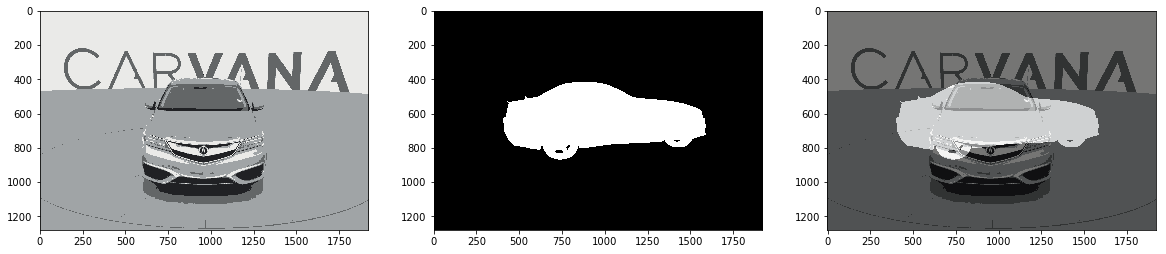

In [114]:
plt.subplot(1, 3, 1)
plt.imshow(img[0])
plt.subplot(1, 3, 2)
plt.imshow(mask[0])
plt.subplot(1, 3, 3)
plt.imshow(img[0])
plt.imshow(mask[0], alpha=0.5)
plt.show()

In [23]:
def get_unet(img_height, img_width):
    
    
    ### TODO: Fix U-Net concatenation layers
    
    inputs = Input((img_height, img_width, 3))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [24]:
unet_model = get_unet(img[0].shape[0], img[0].shape[1])

TypeError: __init__() got multiple values for argument 'axis'